In [1]:
# import basic packages for data analysis
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler

In [2]:
clean_set = pd.read_csv('C:/Users/nasqi/Downloads/cleanedData.csv')

### Model Selection For Simple Regression

To find the best model for this dataset, we compare the performance of simple regression and more complex regression models. We use three simple regression models to test the performance of the simpler model and then determine the best simpler regression model for this dataset.

Use forward and backward selection method to determine the best linear regression model.

In [3]:
def forward_selection(X_train, y_train, significance_level=0.05):
    # Start with no predictors
    initial_features = X_train.columns.tolist()
    best_features = []
    
    while len(initial_features) > 0:  # Iterate over the set of all features
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        
        for new_column in remaining_features: # Iterate over the remaining features not yet included
            # Fit model with the selected features and one additional feature
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[best_features + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        min_p_value = new_pval.min()
        if min_p_value < significance_level: # If the p-value is below the significance level, add it to the best features
            best_features.append(new_pval.idxmin())
        else:
            break

    return best_features, len(best_features)

In [4]:
def backward_elimination(X_train, y_train, significance_level=0.05):
    # Start with all predictors
    features = X_train.columns.tolist()
    
    # Iterate as long as there are features to consider
    while len(features) > 0:
        features_with_constant = sm.add_constant(X_train[features])
        p_values = sm.OLS(y_train, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        
        # If the max p-value is above the significance level, remove that feature
        if max_p_value >= significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
            
    return features, len(features)

In [5]:
# Data split function
def split_group(group):
    # Sort values in asecending ordinal date_time
    group = group.sort_values(by='date_time')
    # Non-random, ordered train-test split
    train_set, test_set = train_test_split(group, test_size=0.3, shuffle = False, stratify = None)
    return train_set, test_set

In [6]:
# Define features and target
features = clean_set.drop('airTemp', axis=1) # 11 variables
target = clean_set['airTemp'] # predict air temperature

In [36]:
# Group by combination of latitude and longitude
group = clean_set.groupby(['lat', 'long'])

# Apply the split_group function to each group
train_test_sets = group.apply(split_group)

# Construct the train and test set dataframes
train_set = pd.concat([x[0] for x in train_test_sets])
train_set.reset_index(drop=True, inplace=True)

test_set = pd.concat([x[1] for x in train_test_sets])
test_set.reset_index(drop=True, inplace=True)

X_train = train_set.drop(['airTemp'], axis=1)
y_train = train_set['airTemp']
X_test = test_set.drop(['airTemp'], axis=1)
y_test = test_set['airTemp']

In [8]:
# Forward selection
selected_features_forward, count_forward = forward_selection(X_train, y_train)
print("Selected features by forward selection:", selected_features_forward)
print("Number of features selected:", count_forward)

# Backward elimination
selected_features_backward, count_backward = backward_elimination(X_train, y_train)
print("Selected features by backward elimination:", selected_features_backward)
print("Number of features selected:", count_backward)

Selected features by forward selection: ['atmosPStatn', 'lat', 'windDir', 'rad', 'tPrec', 'dpTemp', 'airHum', 'prevHrMinTemp', 'long', 'windSp']
Number of features selected: 10
Selected features by backward elimination: ['tPrec', 'atmosPStatn', 'rad', 'dpTemp', 'prevHrMinTemp', 'airHum', 'windDir', 'windSp', 'lat', 'long']
Number of features selected: 10


The forward and backward stepwise selection methods are returning 10 variables as significant, it suggests that each variable in our dataset might be contributing meaningfully to the prediction of air temperature.

In [38]:
X_train = X_train.drop(['date_time'], axis=1)
X_test = X_test.drop(['date_time'], axis=1)

In [41]:
print(X_train.columns)
print(X_test.columns)

Index(['tPrec', 'atmosPStatn', 'rad', 'dpTemp', 'prevHrMinTemp', 'airHum',
       'windDir', 'windSp', 'lat', 'long'],
      dtype='object')
Index(['tPrec', 'atmosPStatn', 'rad', 'dpTemp', 'prevHrMinTemp', 'airHum',
       'windDir', 'windSp', 'lat', 'long'],
      dtype='object')


In [42]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate performance 
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, r2

In [43]:
# Function to find the optimal alpha level for ridge and lasso regression model
def k_fold_cv(model, X_train, y_train):
    # k-fold-cross validation to find optimal alpha level
    folds = KFold(n_splits = 5, shuffle = True, random_state = 141)
    # Range for parameters
    parameters = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0]}
    model_cv = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'r2', cv = folds
                           , return_train_score = True, verbose = 1)
    model_cv.fit(X_train, y_train)
    alpha = model_cv.best_params_
    
    return alpha

In [44]:
Ridge_model = Ridge()
optimal_alpha_ridge = k_fold_cv(Ridge_model, X_train, y_train)
print("Best alpha for Ridge Regression:", optimal_alpha_ridge)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best alpha for Ridge Regression: {'alpha': 10.0}


In [45]:
Lasso_model = Lasso()
optimal_alpha_lasso = k_fold_cv(Lasso_model, X_train, y_train)
print("Best alpha for Lasso Regression:", optimal_alpha_lasso)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best alpha for Lasso Regression: {'alpha': 0.001}


We use k-fold cross validation and set the alpha range between 0.001 and 10.0, to find the best alpha level for the Ridge and Lasso regression. The best alpha level for Ridge regression is 10.0. And the best alpha level for Lasso regression is 0.001.

In [46]:
# Initialize a linear regression model
linear_model = LinearRegression()

# Initialize a ridge regression model
ridge_model = Ridge(alpha = 10.0, random_state = 141)  

# Initialize a lasso regression model
lasso_model = Lasso(alpha = 0.001, random_state = 141)    

In [47]:
# Evaluate Linear Regression
linear_mse, linear_mae, linear_r2 = train_and_evaluate(linear_model, X_train, X_test, y_train, y_test)

# Evaluate Ridge Regression
ridge_mse, ridge_mae, ridge_r2 = train_and_evaluate(ridge_model, X_train, X_test, y_train, y_test)

# Evaluate Lasso Regression
lasso_mse, lasso_mae, lasso_r2 = train_and_evaluate(lasso_model, X_train, X_test, y_train, y_test)

In [49]:
# Function to train and evaluate a normalized model
def train_and_evaluate_normalized(model, X_train, X_test, y_train, y_test):
    # Normalized the data
    std_scalar = StandardScaler()
    std_scalar.fit(X_train)
    X_train = std_scalar.transform(X_train)
    X_test = std_scalar.transform(X_test)
    
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate performance 
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Model Performance for {type(model).__name__}")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r')
    plt.show()
    
    return mse, mae, r2

In [50]:
# Initialize a linear regression model
Nor_linear_model = LinearRegression()

# Initialize a ridge regression model
Nor_ridge_model = Ridge(alpha = 10.0, random_state = 141)  

# Initialize a lasso regression model
Nor_lasso_model = Lasso(alpha = 0.01, random_state = 141)  

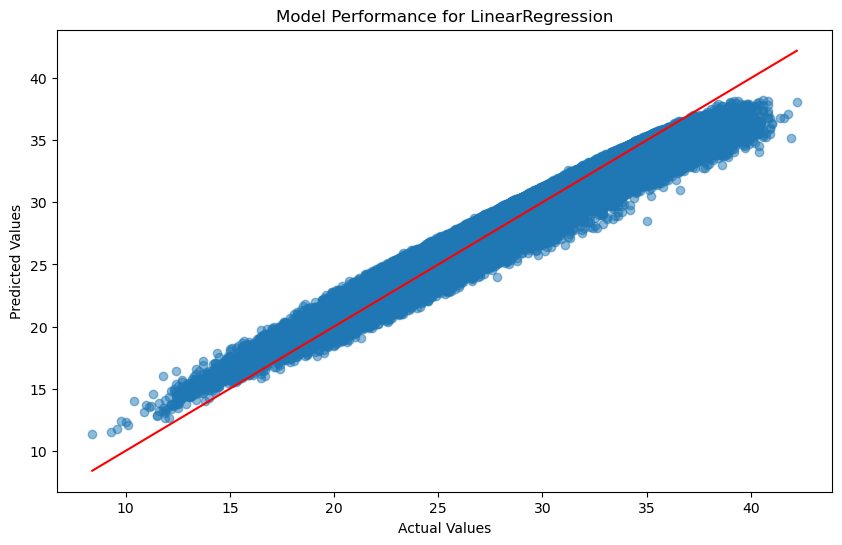

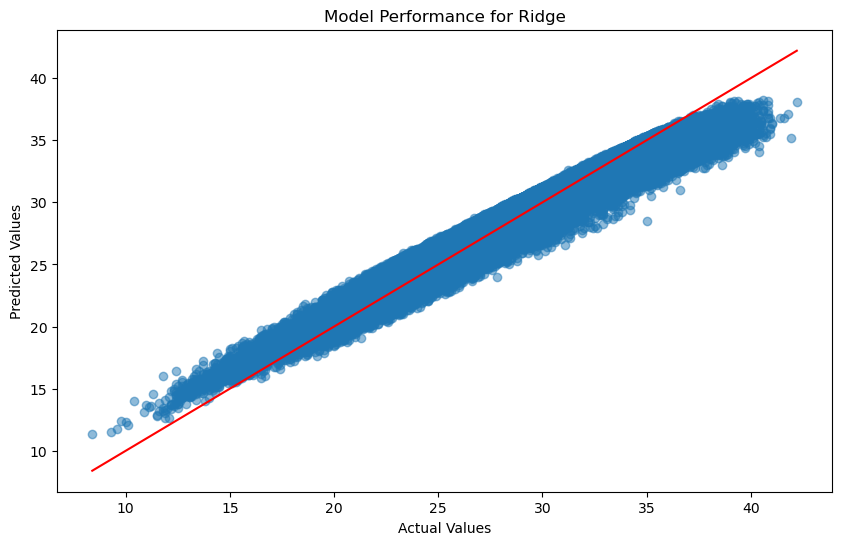

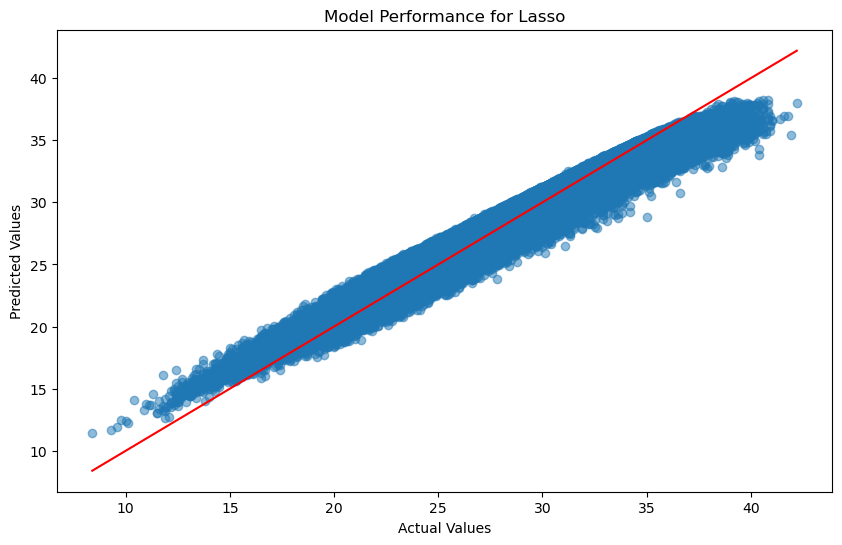

In [18]:
# Evaluate Linear Regression
Nor_linear_mse, Nor_linear_mae, Nor_linear_r2 = train_and_evaluate_normalized(Nor_linear_model, X_train, X_test, y_train, y_test)

# Evaluate Ridge Regression
Nor_ridge_mse, Nor_ridge_mae, Nor_ridge_r2 = train_and_evaluate_normalized(Nor_ridge_model, X_train, X_test, y_train, y_test)

# Evaluate Lasso Regression
Nor_lasso_mse, Nor_lasso_mae, Nor_lasso_r2 = train_and_evaluate_normalized(Nor_lasso_model, X_train, X_test, y_train, y_test)

The three scatter plots visualize the performance of the three simple regression models: Linear, Ridge, and Lasso.
As we can see above, these three plots were almost identical visually.

In [51]:
print("Normalized Linear Regression - MSE:", Nor_linear_mse, "MAE:", Nor_linear_mae, "R2:", Nor_linear_r2)
print("Normalized Ridge Regression - MSE:", Nor_ridge_mse, "MAE:", Nor_ridge_mae, "R2:", Nor_ridge_r2)
print("Normalized Lasso Regression - MSE:", Nor_lasso_mse, "MAE:", Nor_lasso_mae, "R2:", Nor_lasso_r2)

Normalized Linear Regression - MSE: 0.36822938764092905 MAE: 0.44364334283269685 R2: 0.9724557191078737
Normalized Ridge Regression - MSE: 0.3682269699420409 MAE: 0.4436451123176414 R2: 0.9724558999564956
Normalized Lasso Regression - MSE: 0.3696850463836768 MAE: 0.44797478038145383 R2: 0.9723468329770024


In [52]:
print("Linear Regression - MSE:", linear_mse, "MAE:", linear_mae, "R2:", linear_r2)
print("Ridge Regression - MSE:", ridge_mse, "MAE:", ridge_mae, "R2:", ridge_r2)
print("Lasso Regression - MSE:", lasso_mse, "MAE:", lasso_mae, "R2:", lasso_r2)

Linear Regression - MSE: 0.36824203248965887 MAE: 0.44359949990261566 R2: 0.9724547732483716
Ridge Regression - MSE: 0.3682420339079092 MAE: 0.4435994168201423 R2: 0.9724547731422837
Lasso Regression - MSE: 0.3682288466543768 MAE: 0.44358784558379005 R2: 0.9724557595747295


The values of MSE, MAE, and R2 were almost identical between the original model and the normalized model for the three simpler regression models. This suggests that normalization of the input data does not significantly affect the performance of these regression models for this particular dataset. 

Lasso regression, which stands for Least Absolute Shrinkage and Selection Operator, can be particularly useful when we have a large number of features. It has the capability to perform feature selection as part of its function. Given that all three values (MSE, MAE, and R-squared) across the three different regression models (Linear, Ridge, and Lasso) are almost the same, this indicates that for this particular dataset, all three models perform similarly in terms of prediction error and explained variance. Considering Lasso's ability to handle datasets with many features effectively, we select it as the best simpler regression model to compare performance with more complex models.